**Discuss feature extraction power of your favorite CNN pretrained by ImageNet datset before and after transfer learning by MNIST didgit dataset by plotting high dimensional feature vectors on 2D plane using three dimension reduction techniques.**

# Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical

# Load and preprocess MNIST

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Convert to 3 channels and normalize

In [20]:
x_train = np.stack([x_train]*3, axis=-1).astype("float32") / 255.0
x_test = np.stack([x_test]*3, axis=-1).astype("float32") / 255.0

# Reduce size to avoid OOM



In [21]:
x_train = x_train[:3000]
y_train = y_train[:3000]
x_test = x_test[:1000]
y_test = y_test[:1000]


# Resize using batches (to prevent OOM)

In [22]:
def safe_resize(images, size=(224, 224), batch_size=64):
    resized_batches = []
    for i in range(0, len(images), batch_size):
        batch = tf.image.resize(images[i:i+batch_size], size)
        resized_batches.append(batch)
    return tf.concat(resized_batches, axis=0)

x_train = safe_resize(x_train)
x_test = safe_resize(x_test)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Load pretrained MobileNetV2 base

In [23]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Feature extractor BEFORE fine-tuning

In [24]:
feature_model_before = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Feature extractor AFTER fine-tuning

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
finetuned_model = Model(inputs=base_model.input, outputs=output)

# Freeze base model for transfer learning

In [26]:
base_model.trainable = False
finetuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier head

In [27]:
finetuned_model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=3, batch_size=32)

Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.6462 - loss: 1.0928 - val_accuracy: 0.8890 - val_loss: 0.3340
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9432 - loss: 0.1991 - val_accuracy: 0.9050 - val_loss: 0.2705
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9578 - loss: 0.1349 - val_accuracy: 0.9210 - val_loss: 0.2339


# Get feature vectors

In [28]:
features_before = feature_model_before.predict(x_test)
features_after = finetuned_model.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step


# Dimensionality Reduction & Plotting

In [29]:
def plot_reduction(X, y, method, title):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        idxs = (y == i)
        plt.scatter(X[idxs, 0], X[idxs, 1], label=str(i), alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# PCA

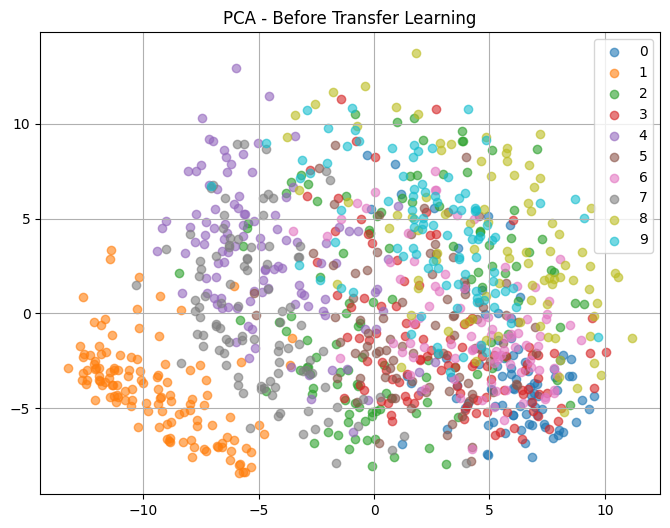

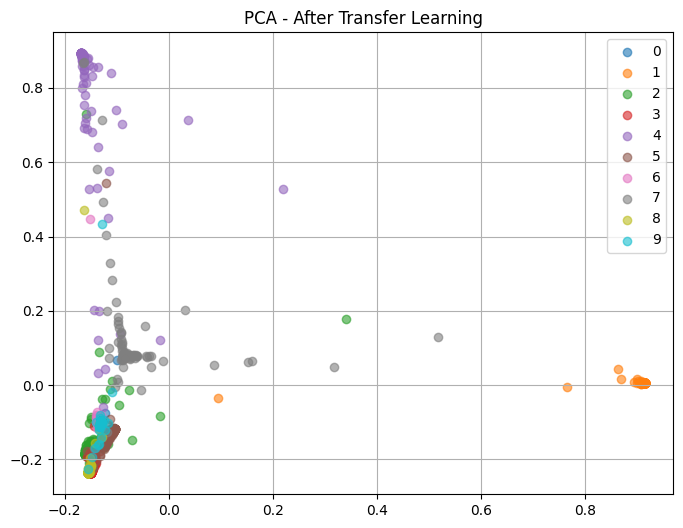

In [30]:
pca_before = PCA(n_components=2).fit_transform(features_before)
pca_after = PCA(n_components=2).fit_transform(features_after)
plot_reduction(pca_before, y_test, 'PCA', 'PCA - Before Transfer Learning')
plot_reduction(pca_after, y_test, 'PCA', 'PCA - After Transfer Learning')

# t-SNE

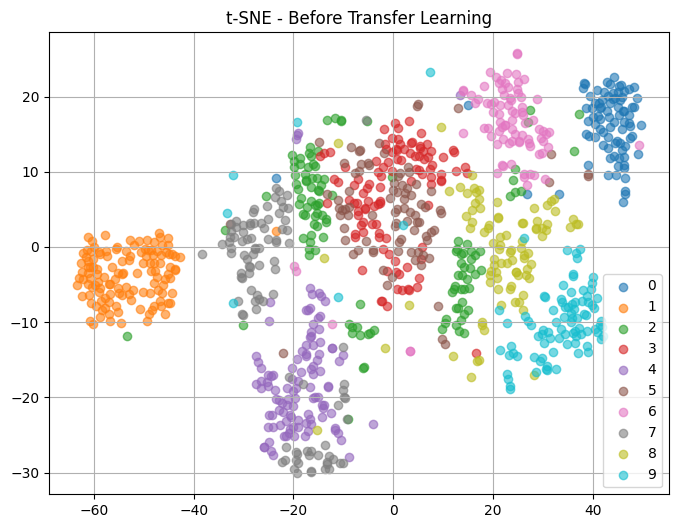

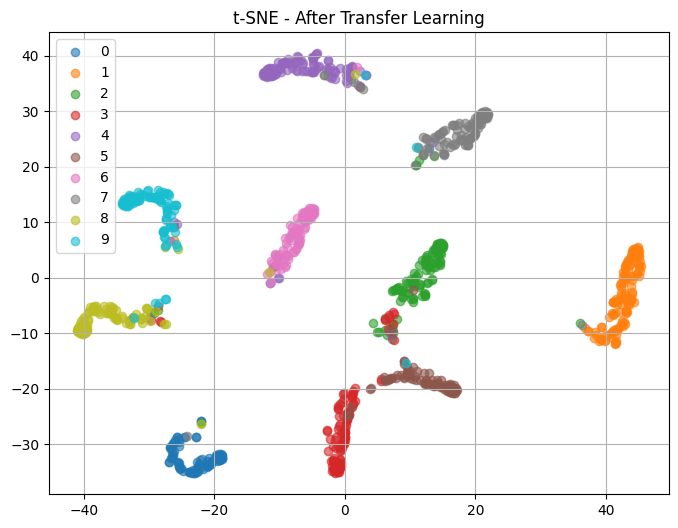

In [31]:
tsne_before = TSNE(n_components=2, perplexity=30).fit_transform(features_before)
tsne_after = TSNE(n_components=2, perplexity=30).fit_transform(features_after)
plot_reduction(tsne_before, y_test, 't-SNE', 't-SNE - Before Transfer Learning')
plot_reduction(tsne_after, y_test, 't-SNE', 't-SNE - After Transfer Learning')

# UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


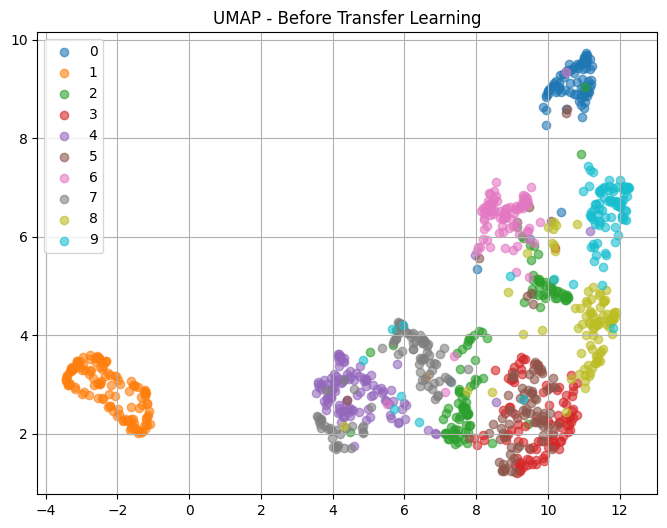

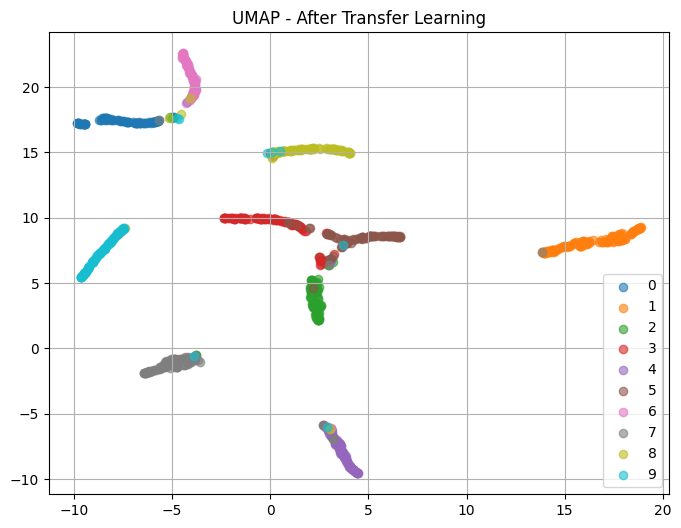

In [32]:
umap_before = umap.UMAP(n_components=2).fit_transform(features_before)
umap_after = umap.UMAP(n_components=2).fit_transform(features_after)
plot_reduction(umap_before, y_test, 'UMAP', 'UMAP - Before Transfer Learning')
plot_reduction(umap_after, y_test, 'UMAP', 'UMAP - After Transfer Learning')